# What Makes a Hit Song a Hit?
### by Catherine Lau and Rhea Lieberman 

## Introduction
Have you ever wondered what makes a popular song a hit? Is there a specific formula to make a song top the charts? How can we predict if and where a song will be popular?

These questions are our motivation behind this tutorial.  We used the top 200 most streamed tracks on  Charts, https://spotifycharts.com/regional,  of the week of December 5, 2019 in every country  to attempt to answer them.  Spotify is the most popular music streaming platform with about 217 million monthly active users worldwide, which is why we chose to use their data.  Using the Spotify API, we also pulled the audio features for each song in order to analyze what commonalities we can find amongst these tracks.  

## Getting Started
Here are the libraries we will be using during this tutorial:

In [31]:
import pandas as pd
!pip install spotipy
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import time
import numpy as np
!pip install folium
import folium
import requests
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
from scipy import stats

During this tutorial we will be discussing and analyzing audio features of top Spotify tracks.  We define these features here for reference.

<b>Danceability:</b> how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity <br>
<b>Energy:</b> perceptual measure of intensity and activity <br>
<b>Key:</b> estimated overall key of the track <br>
<b>Loudness:</b> overall loudness of a track in decibels (dB) <br>
<b>Mode:</b> the modality (major or minor) of a track <br>
<b>Speechiness:</b> the presence of spoken words in a track <br>
<b>Acousticness:</b> a confidence measure from 0.0 to 1.0 of whether the track is acoustic <br>
<b>Instrumentalness:</b> predicts whether a track contains no vocals <br>
<b>Liveness:</b> detects the presence of an audience in the recording <br>
<b>Valence:</b> a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track <br>
<b>Tempo:</b> the overall estimated tempo of a track in beats per minute (BPM) <br>

## Data Collection
To get started, as stated from above, we used the Spotify Charts website to retrieve data for each country’s top 200 songs for the week of December 5th. Thankfully, Spotify’s website converted this data to a CSV file for us. Using each song’s unique URL id, we used Spotify’s python library to query its audio features. Since our dataset is quite large, this took a while to run. We ran it once and then exported it to a csv file to read in the future. 


In [32]:
data = pd.read_csv("regional-weekly-latest.csv", encoding = "ISO-8859-1")
data

,Position,Track Name,Artist,Streams,URL,Country
0,1,Heartless,The Weeknd,11224390,https://open.spotify.com/track/57vxBYXtHMk6H1a...,United States
1,2,ROXANNE,Arizona Zervas,10198981,https://open.spotify.com/track/696DnlkuDOXcMAn...,United States
2,3,Blinding Lights,The Weeknd,9583216,https://open.spotify.com/track/0sf12qNH5qcw8qp...,United States
3,4,Circles,Post Malone,7959651,https://open.spotify.com/track/21jGcNKet2qwijl...,United States
4,5,everything i wanted,Billie Eilish,7130246,https://open.spotify.com/track/3ZCTVFBt2Brf31R...,United States
...,...,...,...,...,...,...
6595,196,Heat (feat. Gunna),Chris Brown,10175,https://open.spotify.com/track/1GIYmwtBbPSHrqc...,South Africa
6596,197,Bones (feat. OneRepublic),Galantis,10073,https://open.spotify.com/track/1pfgsjmxVZhoZpe...,South Africa
6597,198,Panini - DaBaby Remix,Lil Nas X,10033,https://open.spotify.com/track/4SDgTLDYrJ2UrHb...,South Africa
6598,199,Abuyile Amakhosi,Kabza De Small,10024,https://open.spotify.com/track/09qyQr0PrUCB0V9...,South Africa


## Tidying and Modifying the Data
To make the dataset cleaner we decided to only look at the top 100 songs of each country. We dropped all null columns and fixed some typos in the dataset that will be important later on. 


In [33]:
#only use top 100 of each country
data = data.loc[data['Position'] <= 100]

#rewriting some country names so they fit the properties for world countries json file that will be used later
data.loc[(data.Country == 'United States'),'Country']='United States of America'
data.loc[(data.Country == 'Portuagl'),'Country']='Portugal'
data

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Position,Track Name,Artist,Streams,URL,Country
0,1,Heartless,The Weeknd,11224390,https://open.spotify.com/track/57vxBYXtHMk6H1a...,United States of America
1,2,ROXANNE,Arizona Zervas,10198981,https://open.spotify.com/track/696DnlkuDOXcMAn...,United States of America
2,3,Blinding Lights,The Weeknd,9583216,https://open.spotify.com/track/0sf12qNH5qcw8qp...,United States of America
3,4,Circles,Post Malone,7959651,https://open.spotify.com/track/21jGcNKet2qwijl...,United States of America
4,5,everything i wanted,Billie Eilish,7130246,https://open.spotify.com/track/3ZCTVFBt2Brf31R...,United States of America
...,...,...,...,...,...,...
6495,96,lovely (with Khalid),Billie Eilish,15686,https://open.spotify.com/track/0u2P5u6lvoDfwTY...,South Africa
6496,97,Fire,DJ Big Sky,15551,https://open.spotify.com/track/2nVAnGGOKDTzCw5...,South Africa
6497,98,7 rings,Ariana Grande,15449,https://open.spotify.com/track/6ocbgoVGwYJhOv1...,South Africa
6498,99,i'm so tired...,Lauv,15141,https://open.spotify.com/track/2iwS33Jfev1QBiu...,South Africa


In [34]:
username = 'catherinelau.home@gmail.com'
scope = 'user-library-read'
client_id= "67820054fecc4ef887e50cd56a1247e2"
client_secret= "d25c2ed810844ca9a84fd127d8c7d3c0"
redirect_uri = 'https://www.google.com/'
token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)

In [17]:
danceability = []
energy = []
key = []
loudness = []
mode = []
speechiness = []
acousticness = []
instrumentalness = []
liveness = []
valence = []
tempo = []

sleep_min = 5
sleep_max = 10
start_time = time.time()
request_count = 0
track_count = 0
for track in data['URL']:
    features = sp.audio_features(track)
    if features[0] is None:
        danceability.append(None)
        energy.append(None)
        key.append(None)
        loudness.append(None)
        mode.append(None)
        speechiness.append(None)
        acousticness.append(None)
        instrumentalness.append(None)
        liveness.append(None)
        valence.append(None)
        tempo.append(None)
    else: 
        danceability.append(features[0]['danceability'])
        energy.append(features[0]['energy'])
        key.append(features[0]['key'])
        loudness.append(features[0]['loudness'])
        mode.append(features[0]['mode'])
        speechiness.append(features[0]['speechiness'])
        acousticness.append(features[0]['acousticness'])
        instrumentalness.append(features[0]['instrumentalness'])
        liveness.append(features[0]['liveness'])
        valence.append(features[0]['valence'])
        tempo.append(features[0]['tempo'])
    track_count+=1
    request_count+=1
    if request_count % 100 == 0:
        print(str(request_count) + " songs completed")
        time.sleep(np.random.uniform(sleep_min, sleep_max))
        print('Loop #: {}'.format(request_count))
        print('Elapsed Time: {} seconds'.format(time.time() - start_time))

data['Danceability'] = danceability
data['Energy'] = energy
data['Key'] = key
data['Loudness'] = loudness
data['Mode'] = mode
data['Speechiness'] = speechiness
data['Acousticness'] = acousticness
data['Instrumentalness'] = instrumentalness
data['Liveness'] = liveness
data['Valence'] = valence
data['Tempo'] = tempo

    
data
#export to csv
#data.to_csv('full-regional2.csv', header=True, index=False) 

retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
100 songs completed
Loop #: 100
Elapsed Time: 25.187342882156372 seconds
retrying ...4secs
retrying ...1secs
200 songs completed
Loop #: 200
Elapsed Time: 53.78099584579468 seconds
300 songs completed
Loop #: 300
Elapsed Time: 76.30596446990967 seconds
400 songs completed
Loop #: 400
Elapsed Time: 95.22147345542908 seconds
500 songs completed
Loop #: 500
Elapsed Time: 113.52805185317993 seconds
600 songs completed
Loop #: 600
Elapsed Time: 131.48441076278687 seconds
700 songs completed
Loop #: 700
Elapsed Time: 150.81561422348022 seconds
800 songs completed
Loop #: 800
Elapsed Time: 168.57828044891357 seconds
900 songs completed
Loop #: 900
Elapsed Time: 187.0457684993744 seconds
1000 songs completed
Loop #: 1000
Elapsed Time: 205.95880675315857 seconds
1100 songs completed
Loop #: 1100
Elapsed Time: 220.61890387535095 seconds
1200 songs completed
Loop #: 1200
Elapsed Time: 236.14875149726868 seconds
retrying ...1s

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

,Position,Track Name,Artist,Streams,URL,Country,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,1,Heartless,The Weeknd,11224390,https://open.spotify.com/track/57vxBYXtHMk6H1a...,United States of America,0.531,0.750,10.0,-5.831,0.0,0.1110,0.00632,0.000076,0.1170,0.198,169.954
1,2,ROXANNE,Arizona Zervas,10198981,https://open.spotify.com/track/696DnlkuDOXcMAn...,United States of America,0.621,0.601,6.0,-5.616,0.0,0.1480,0.05220,0.000000,0.4600,0.457,116.735
2,3,Blinding Lights,The Weeknd,9583216,https://open.spotify.com/track/0sf12qNH5qcw8qp...,United States of America,0.513,0.796,1.0,-4.075,1.0,0.0629,0.00147,0.000209,0.0938,0.345,171.017
3,4,Circles,Post Malone,7959651,https://open.spotify.com/track/21jGcNKet2qwijl...,United States of America,0.695,0.762,0.0,-3.497,1.0,0.0395,0.19200,0.002440,0.0863,0.553,120.042
4,5,everything i wanted,Billie Eilish,7130246,https://open.spotify.com/track/3ZCTVFBt2Brf31R...,United States of America,0.704,0.225,6.0,-14.454,0.0,0.0994,0.90200,0.657000,0.1060,0.243,120.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,96,lovely (with Khalid),Billie Eilish,15686,https://open.spotify.com/track/0u2P5u6lvoDfwTY...,South Africa,0.351,0.296,4.0,-10.109,0.0,0.0333,0.93400,0.000000,0.0950,0.120,115.284
6496,97,Fire,DJ Big Sky,15551,https://open.spotify.com/track/2nVAnGGOKDTzCw5...,South Africa,0.648,0.556,11.0,-7.323,0.0,0.2120,0.01890,0.000326,0.0494,0.642,114.022
6497,98,7 rings,Ariana Grande,15449,https://open.spotify.com/track/6ocbgoVGwYJhOv1...,South Africa,0.778,0.317,1.0,-10.732,0.0,0.3340,0.59200,0.000000,0.0881,0.327,140.048
6498,99,i'm so tired...,Lauv,15141,https://open.spotify.com/track/2iwS33Jfev1QBiu...,South Africa,0.599,0.733,11.0,-7.058,1.0,0.2030,0.17600,0.000000,0.2420,0.534,102.211


In [9]:
data = pd.read_csv("full-regional2.csv", encoding = "ISO-8859-1")

data = data.dropna()
data

,Position,Track Name,Artist,Streams,URL,Country,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,1,Heartless,The Weeknd,11224390,https://open.spotify.com/track/57vxBYXtHMk6H1a...,United States of America,0.531,0.750,10.0,-5.831,0.0,0.1110,0.00632,0.000076,0.1170,0.198,169.954
1,2,ROXANNE,Arizona Zervas,10198981,https://open.spotify.com/track/696DnlkuDOXcMAn...,United States of America,0.621,0.601,6.0,-5.616,0.0,0.1480,0.05220,0.000000,0.4600,0.457,116.735
2,3,Blinding Lights,The Weeknd,9583216,https://open.spotify.com/track/0sf12qNH5qcw8qp...,United States of America,0.513,0.796,1.0,-4.075,1.0,0.0629,0.00147,0.000209,0.0938,0.345,171.017
3,4,Circles,Post Malone,7959651,https://open.spotify.com/track/21jGcNKet2qwijl...,United States of America,0.695,0.762,0.0,-3.497,1.0,0.0395,0.19200,0.002440,0.0863,0.553,120.042
4,5,everything i wanted,Billie Eilish,7130246,https://open.spotify.com/track/3ZCTVFBt2Brf31R...,United States of America,0.704,0.225,6.0,-14.454,0.0,0.0994,0.90200,0.657000,0.1060,0.243,120.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,96,lovely (with Khalid),Billie Eilish,15686,https://open.spotify.com/track/0u2P5u6lvoDfwTY...,South Africa,0.351,0.296,4.0,-10.109,0.0,0.0333,0.93400,0.000000,0.0950,0.120,115.284
3296,97,Fire,DJ Big Sky,15551,https://open.spotify.com/track/2nVAnGGOKDTzCw5...,South Africa,0.648,0.556,11.0,-7.323,0.0,0.2120,0.01890,0.000326,0.0494,0.642,114.022
3297,98,7 rings,Ariana Grande,15449,https://open.spotify.com/track/6ocbgoVGwYJhOv1...,South Africa,0.778,0.317,1.0,-10.732,0.0,0.3340,0.59200,0.000000,0.0881,0.327,140.048
3298,99,i'm so tired...,Lauv,15141,https://open.spotify.com/track/2iwS33Jfev1QBiu...,South Africa,0.599,0.733,11.0,-7.058,1.0,0.2030,0.17600,0.000000,0.2420,0.534,102.211


## Exploratory Data Analysis
Here, we are sorting the data by the amount of streams and visualizing this geographically using a folium map. To quanitfy this data we constructed a bar plot to see exactly which countries stream the most music through Spotify. This information will be useful to us later on.

In [10]:
#number of streams per country (folium map/heat map)
#list of all countries
countries = data['Country'].tolist()

country_geo = 'world-countries.json'

data_to_map = data[['Streams', 'Country']]
data_to_map = data_to_map.groupby('Country', as_index=False).sum()

streams_map = folium.Map(location=[0, 0], zoom_start=2)
streams_map.choropleth(geo_data=country_geo, data=data_to_map,
             columns=['Country', 'Streams'],
             key_on='feature.properties.name',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Number of Streams')


folium.LayerControl().add_to(streams_map)
streams_map

/opt/conda/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


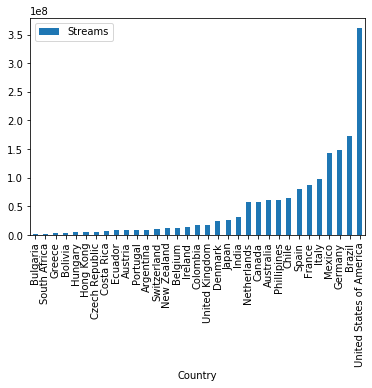

In [6]:
data_to_map = data_to_map.sort_values('Streams')
data_to_map.plot.bar(x='Country', y='Streams')

We can see that the United States has significantly more streams than any other country.  This makes sense considering that Spotify is an American company and that the United States is highly populated compared to other countries where Spotify is popular.

## Getting Ready for Regression Modeling

We want to predict what group of audio features and in what quanitity will most likely lead to a song that will end up in the top 200 charts. We queried 11 different audio features from the Spotify API and want to apply feature selection and dimensionality reduction to select only the features that are relevant in the dataset. Feature selection and dimensionality reduction is important because it prevents overfitting, makes the process simpler, and makes the dataset computationally efficient.

We first started this process by making a pair plot of the different features to visualize general trends based on each feature comparing with other features. Features that are correlated moved in a general upward or downware trend


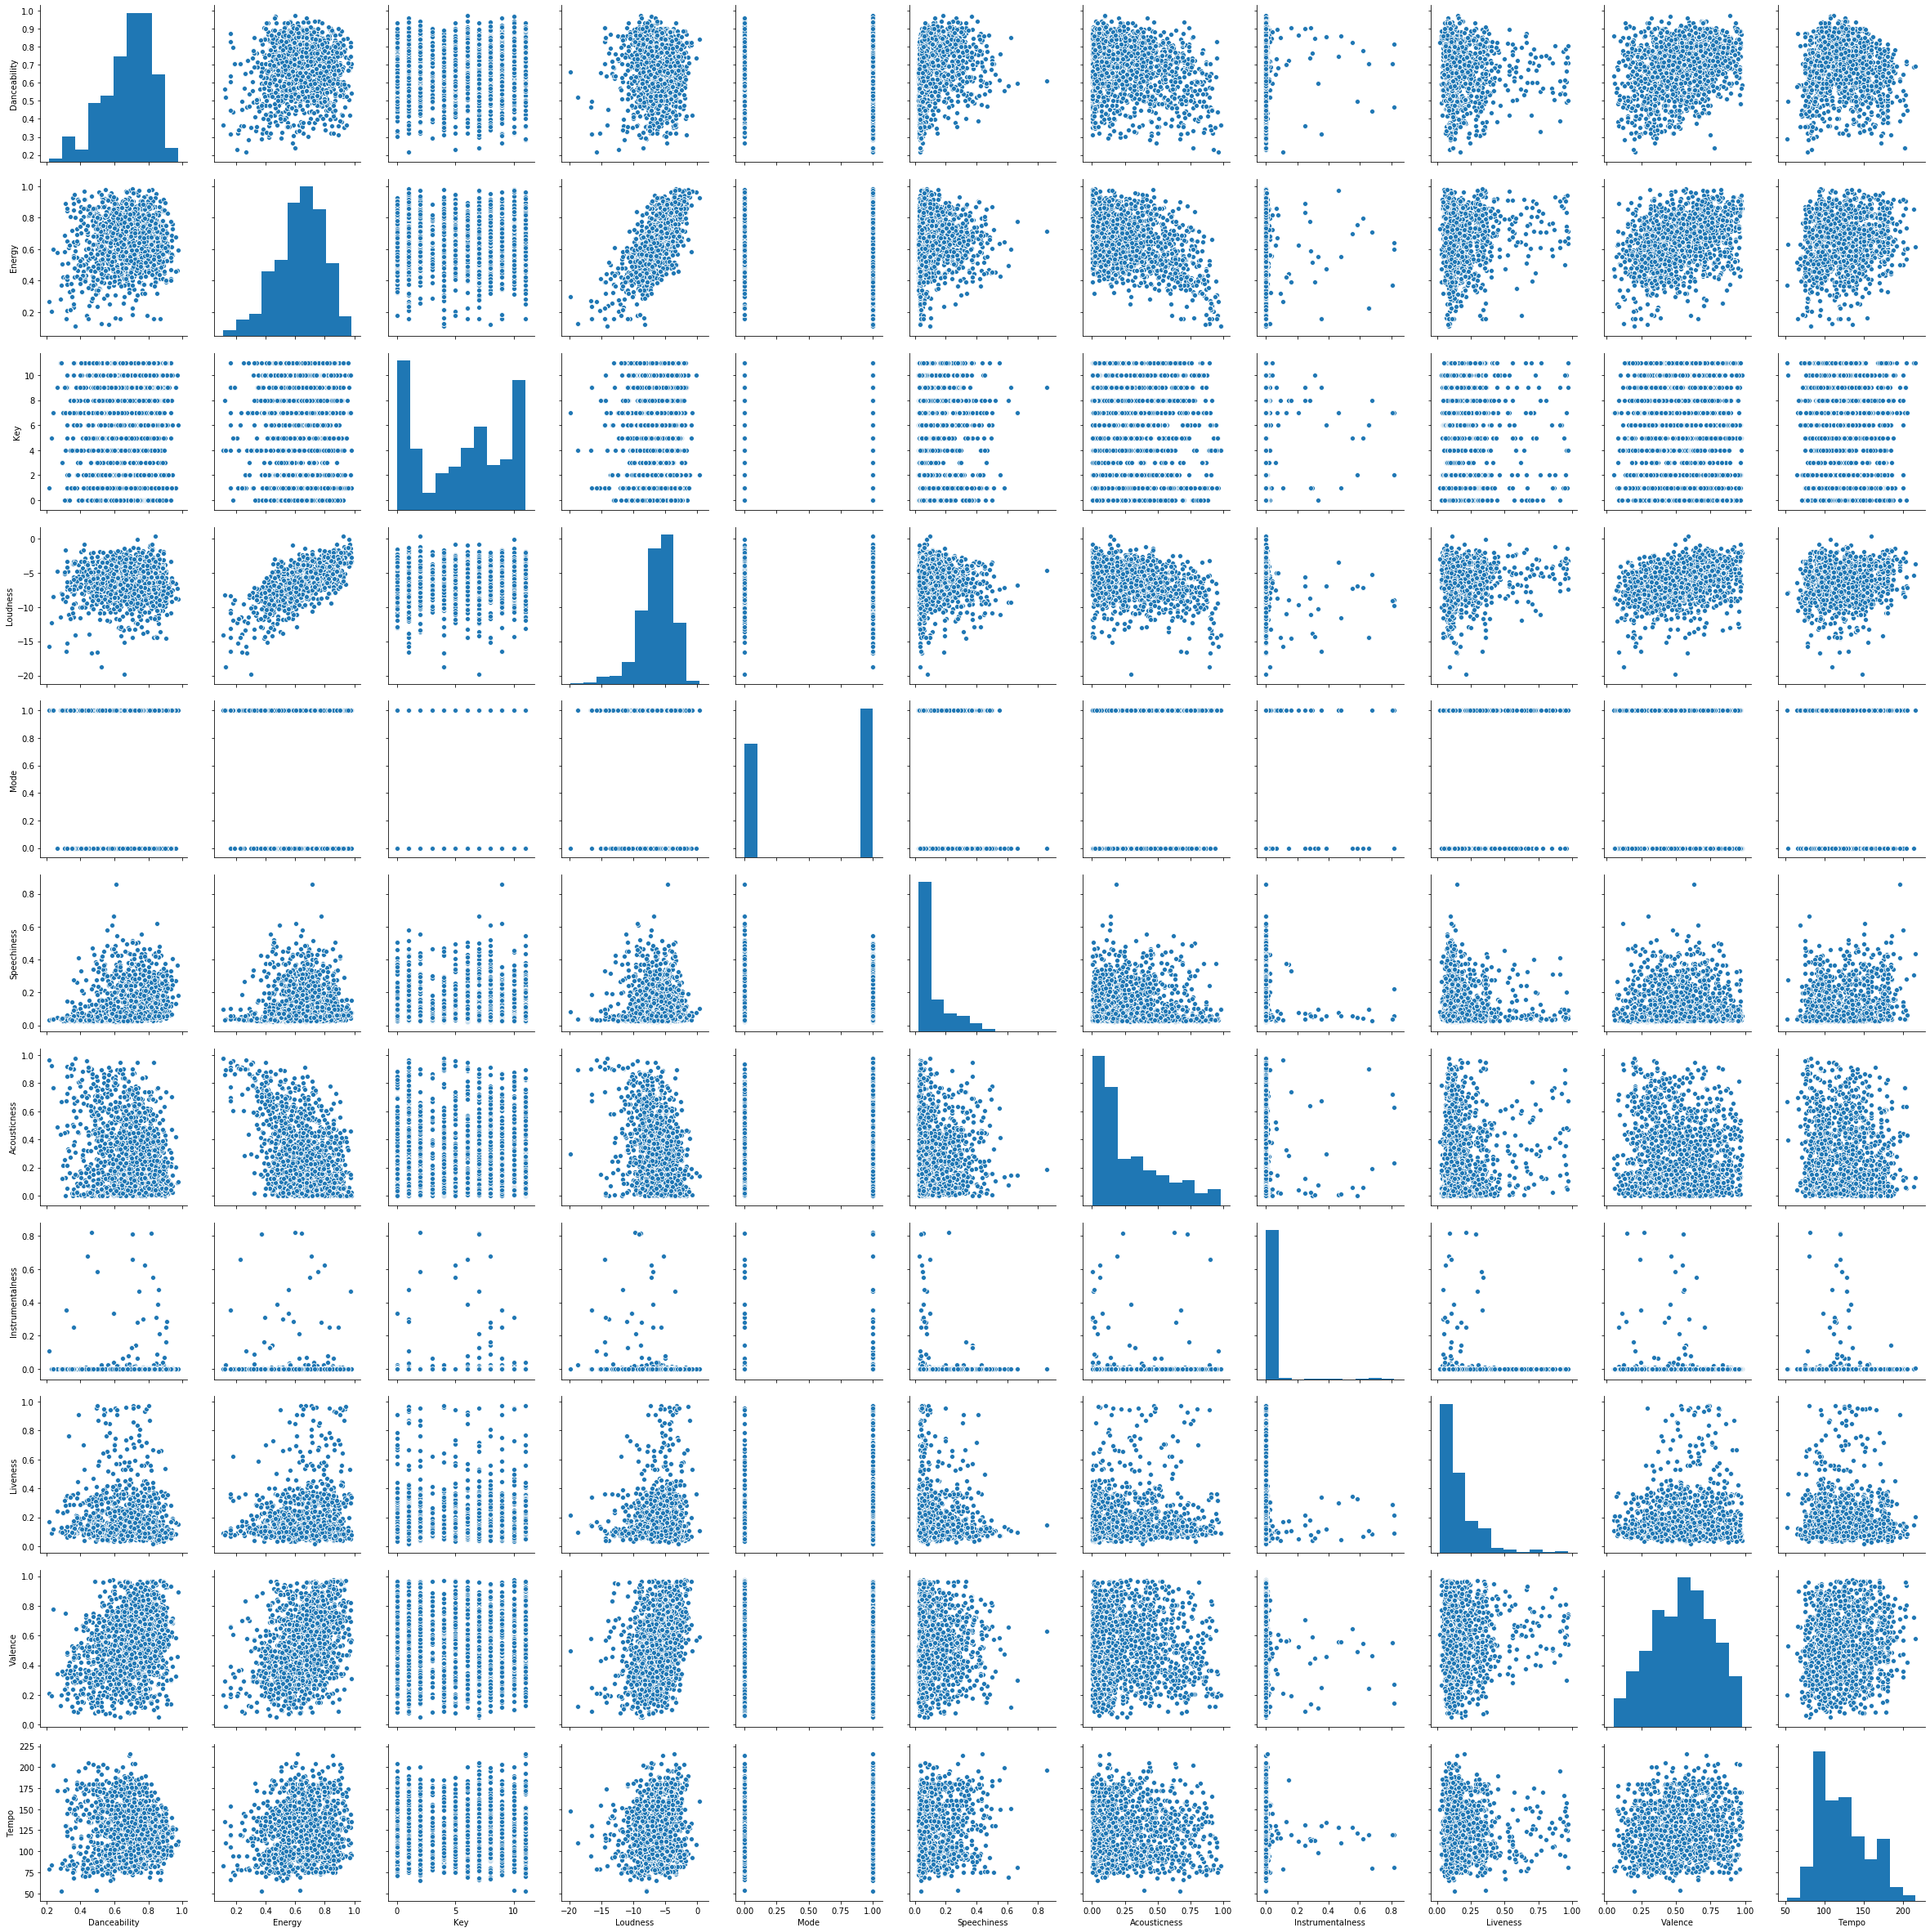

In [13]:
cols = ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode','Speechiness',
        'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']
sns.pairplot(data[cols], height=3.0)
plt.show()

To quanitfy the degree of correlation, we constructed a covariance matrix to show how closely each variable correlates with each other. We assumed that variables that were closely correlated had a correlation coefficient of 0.4. Since those variables are closely related, we do not have to select both of them when running a model. After this process we were able to remove two variables from the feature list


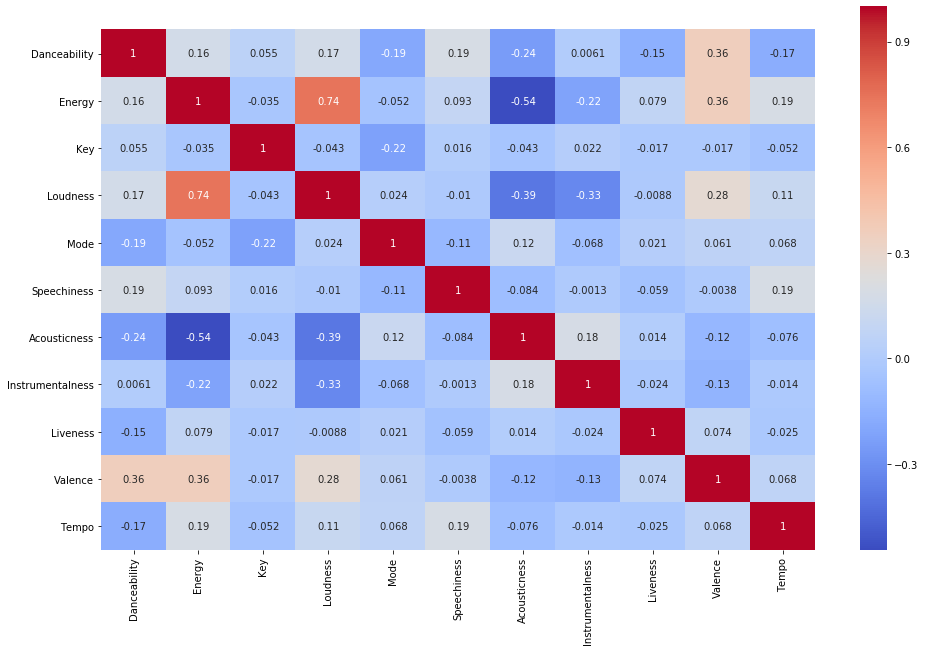

In [14]:
cols = data[['Danceability', 'Energy', 'Key', 'Loudness', 'Mode','Speechiness',
        'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']]
plt.figure(figsize = (16,10))
hm = sns.heatmap(cols.corr(), cmap="coolwarm", annot=True)
hm.set_ylim(len(cols.corr()), -0.5) 
plt.show()

In [17]:
corr = cols.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) > 0.4:
            if columns[j]:
                columns[j] = False
selected_columns = cols.columns[columns]
selected_columns

Index(['Danceability', 'Energy', 'Key', 'Mode', 'Speechiness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo'],
      dtype='object')

Since some songs made it to the top 200 charts in multiple countries, we grouped the data by song while summing up the total streams of that song so we can later use.
Since there was a big range in the number streams of a song depending on the country, we decided to normalize the stream value so that all values are between 0 and 1. This will make training less sensitive to the scale of features and can better evaluate coefficients.


In [20]:
streams_data = data.groupby(['Track Name','Danceability', 'Energy', 'Key', 'Mode', 'Speechiness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo'], as_index=False)['Streams'].sum()
streams_data

,Track Name,Danceability,Energy,Key,Mode,Speechiness,Instrumentalness,Liveness,Valence,Tempo,Streams
0,#31#,0.678,0.917,8.0,0.0,0.0811,0.000000,0.1910,0.700,112.193,27493
1,1 de Abril,0.774,0.648,1.0,1.0,0.2090,0.000000,0.0707,0.300,146.043,124357
2,"10,000 Hours (with Justin Bieber)",0.654,0.630,10.0,1.0,0.0259,0.000000,0.1110,0.430,89.991,7948913
3,100%,0.859,0.675,9.0,0.0,0.0997,0.000014,0.1720,0.610,115.010,2355848
4,1000 Hits,0.899,0.624,6.0,0.0,0.0534,0.001160,0.0885,0.751,132.050,1294671
...,...,...,...,...,...,...,...,...,...,...,...
1422,ÃÃ Vontade (feat. FÃ_nix MG),0.691,0.437,6.0,0.0,0.0608,0.013600,0.1010,0.269,75.603,54004
1423,ÃÃ nos hÃÂ©ros du quotidien,0.695,0.722,9.0,1.0,0.1640,0.000000,0.1440,0.407,119.839,474666
1424,ÃÃ a ira,0.706,0.584,1.0,1.0,0.1240,0.000006,0.1050,0.451,142.040,1406689
1425,ÃÃ a va ÃÂ¤a vient,0.597,0.710,5.0,0.0,0.1310,0.000000,0.0802,0.544,103.870,555842


In [19]:
y_array = np.array(streams_data['Streams'])
scaler = MinMaxScaler(feature_range = (0,1))
normalized_y = scaler.fit_transform(y_array.reshape(-1, 1)).flatten()
denormalized_y = scaler.inverse_transform(normalized_y.reshape(-1, 1)).flatten()

## Regression Models
To predict the number of streams given the selected audio feature we wanted to use Python’s sklearn multiple linear regression. We split the data so that part of it is used to train the model and the other is to test the accuracy of the model. From this, we constructed an equation that can be used to predict the number of streams for a song given the values for the song’s danceability, energy, key, mode, speechiness, instrumentalness, liveness, valence, and tempo.

In [23]:
X = streams_data[selected_columns]
y = normalized_y 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
intercept = regression_model.intercept_
slope = regression_model.coef_
slope
print('Fitted model: y = ' + str(slope[0]) + 'a + ' + str(slope[1]) + 'b + '+ str(slope[2]) + 'c + '
     + str(slope[3]) + 'd + '+ str(slope[4]) + 'e + '+ str(slope[5]) + 'f + '+ str(slope[6]) + 'g + '
     + str(slope[7]) + 'h + ' + str(slope[8]) + 'i + '+ str(intercept))
#where a = danceability, b = energy, c = key, d = mode, e = speechiness, f = instrumentalness, g = liveness
#h = valence, and i = tempo

Fitted model: y = 0.019221316753236364a + -0.03821949218788787b + 0.0008050114686160529c + -0.005281860416916619d + -0.003233856541347058e + 0.07126454817664177f + 0.014445616212038064g + 0.024982826787084533h + 6.829847273612244e-05i + 0.020536997364470424


To visualize the accuracy of our predictions with the model, we plotted the song’s actual number of streams (in blue) and the number of streams that the model predicted (in red). It seems like the blue and red points all lie around the same area which gives the sense that the actual and predicted values are close. 


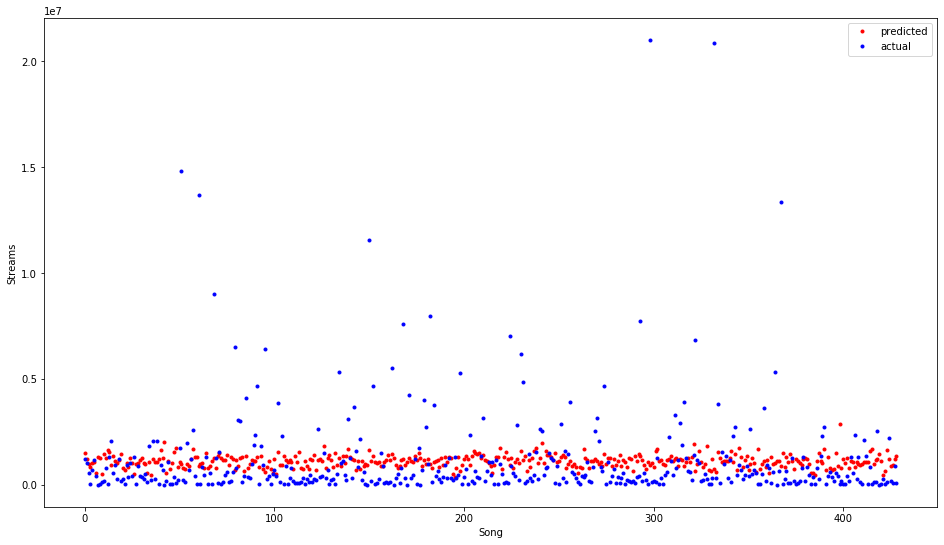

In [25]:
predicted = regression_model.predict(X_test)
predicted = scaler.inverse_transform(predicted.reshape(-1, 1)).flatten()

actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

xx = list(range(len(actual))) # each song is a point on x axis

plt.rcParams["figure.figsize"] = [16,9]
plt.plot(xx, predicted, 'r.', label='predicted')
plt.plot(xx, actual, 'b.', label='actual')
plt.xlabel('Song')
plt.ylabel('Streams')
plt.legend()

To quanitify the accuracy of our predictions, we made a histogram of prediction errors between our training model and the data set. As you can see, the absolute difference between actual and predicted values are all relatively close to zero, making this a pretty good model.


Text(0, 0.5, 'Frequency')

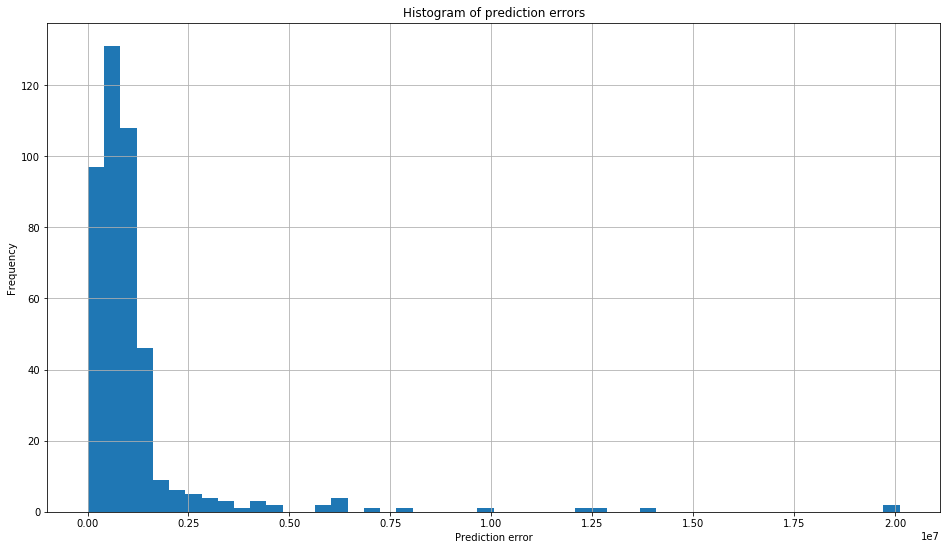

In [27]:
diff = abs(actual - predicted)
diff = pd.Series(diff)
diff.hist(bins = 50)
plt.title('Histogram of prediction errors')
plt.xlabel('Prediction error')
plt.ylabel('Frequency')


We now reject the null hypothesis of a no relationship between a song’s audio features and its number of streams. We peformed an r squared regression score on the model and it has a very low value (0.0175). From this, we can conclude that the data has a significant trend.


In [28]:
print('R squared value: ', regression_model.score(X_train, y_train))

R squared value:  0.017515937220194622


Next, we want to explore how the effect of audio features differs from country to country.  Since streams are concentrated in the top few countries, we'll only being looking at the top 5 countries.  First, we'll separate the data into 5 different tables as follows.

In [21]:
usa = data.loc[data['Country'] == 'United States of America']
brazil = data.loc[data['Country'] == 'Brazil']
germany = data.loc[data['Country'] == 'Germany']
mexico = data.loc[data['Country'] == 'Mexico']
italy = data.loc[data['Country'] == 'Italy']

Next, we want to run a regression on each country's data.  We will be predicting streams from the selected features we identified earlier: danceability, energy, key, mode, speechiness, instrumentalness, liveness, valence, and tempo.  Before we run our regression, we first want to standardize both streams and audio features by replacing their values with their z-score.  This will allow us to compare their coefficients later on.  Here we're calculating the z-scores and looking at the summary for each regression.

In [63]:
usa_z = usa.select_dtypes(include=[np.number]).apply(stats.zscore)

usaModel = ols(formula = """Streams ~ Danceability + Energy + Key + Mode + Speechiness + 
                        Instrumentalness + Liveness + Valence + Tempo""", data=usa_z).fit()
usaModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Streams   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.107
Date:                Thu, 12 Dec 2019   Prob (F-statistic):              0.366
Time:                        04:29:46   Log-Likelihood:                -136.64
No. Observations:                 100   AIC:                             293.3
Df Residuals:                      90   BIC:                             319.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.429e-16      0.100   2.43e-15      1.000      -0.199       0.199
Danceability         0.0742      0.127      0.583      0.562      -0.179       0.327
Energy               0.1278      0.121      1.058      0.293      -0.112       0.368
Key                  0.0413      0.102      0.403      0.688      -0.162       0.245
Mode                 0.0014      0.109      0.013      0.990      -0.215       0.218
Speechiness         -0.2123      0.120     -1.769      0.080      -0.451       0.026
Instrumentalness     0.1808      0.107      1.688      0.095      -0.032       0.394
Liveness             0.0644      0.102      0.630      0.530      -0.139       0.268
Valence             -0.1443      0.115     -1.252      0.214      -0.373       0.085
Tempo                0.1737      0.115      1.505      0.136      -0.056       0.403
==============================================================================
Omnibus:                       56.272   Durbin-Watson:                   0.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.356
Skew:                           2.032   Prob(JB):                     1.86e-39
Kurtosis:                       8.128   Cond. No.                         2.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
brazil_z = brazil.select_dtypes(include=[np.number]).apply(stats.zscore)

brazilModel = ols(formula = """Streams ~ Danceability + Energy + Key + Mode + Speechiness + 
                            Instrumentalness + Liveness + Valence + Tempo""", data=brazil_z).fit()
brazilModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Streams   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.200
Date:                Thu, 12 Dec 2019   Prob (F-statistic):              0.305
Time:                        03:23:02   Log-Likelihood:                -136.23
No. Observations:                 100   AIC:                             292.5
Df Residuals:                      90   BIC:                             318.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.926e-16      0.100   1.93e-15      1.000      -0.198       0.198
Danceability         0.1831      0.116      1.572      0.119      -0.048       0.415
Energy               0.1184      0.114      1.042      0.300      -0.107       0.344
Key                  0.0443      0.103      0.432      0.667      -0.160       0.248
Mode                 0.0849      0.105      0.811      0.419      -0.123       0.293
Speechiness         -0.0379      0.111     -0.342      0.733      -0.258       0.182
Instrumentalness    -0.0970      0.104     -0.933      0.354      -0.303       0.110
Liveness            -0.1156      0.111     -1.038      0.302      -0.337       0.106
Valence             -0.1618      0.126     -1.287      0.202      -0.412       0.088
Tempo                0.2343      0.115      2.037      0.045       0.006       0.463
==============================================================================
Omnibus:                       36.551   Durbin-Watson:                   0.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.407
Skew:                           1.489   Prob(JB):                     5.15e-16
Kurtosis:                       5.835   Cond. No.                         2.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
germany_z = germany.select_dtypes(include=[np.number]).apply(stats.zscore)

germanyModel = ols(formula = """Streams ~ Danceability + Energy + Key + Mode + Speechiness + 
                               Instrumentalness + Liveness + Valence + Tempo""", data=germany_z).fit()
germanyModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Streams   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     2.279
Date:                Thu, 12 Dec 2019   Prob (F-statistic):             0.0237
Time:                        03:30:17   Log-Likelihood:                -131.63
No. Observations:                 100   AIC:                             283.3
Df Residuals:                      90   BIC:                             309.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3.469e-17      0.095   3.65e-16      1.000      -0.189       0.189
Danceability         0.2029      0.124      1.641      0.104      -0.043       0.449
Energy              -0.0109      0.106     -0.103      0.918      -0.221       0.199
Key                 -0.0166      0.101     -0.165      0.870      -0.217       0.184
Mode                -0.1187      0.112     -1.060      0.292      -0.341       0.104
Speechiness          0.2187      0.100      2.184      0.032       0.020       0.418
Instrumentalness     0.1111      0.099      1.118      0.266      -0.086       0.308
Liveness             0.3187      0.106      3.020      0.003       0.109       0.528
Valence             -0.0773      0.113     -0.681      0.497      -0.303       0.148
Tempo                0.0016      0.104      0.015      0.988      -0.205       0.208
==============================================================================
Omnibus:                       51.196   Durbin-Watson:                   0.378
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.865
Skew:                           1.814   Prob(JB):                     1.93e-35
Kurtosis:                       8.021   Cond. No.                         2.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
mexico_z = mexico.select_dtypes(include=[np.number]).apply(stats.zscore)

mexicoModel = ols(formula = """Streams ~ Danceability + Energy + Key + Mode + Speechiness + 
                              Instrumentalness + Liveness + Valence + Tempo""", data=mexico_z).fit()
mexicoModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Streams   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     1.646
Date:                Thu, 12 Dec 2019   Prob (F-statistic):              0.114
Time:                        03:30:38   Log-Likelihood:                -134.27
No. Observations:                 100   AIC:                             288.5
Df Residuals:                      90   BIC:                             314.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.469e-17      0.098  -3.55e-16      1.000      -0.194       0.194
Danceability         0.1256      0.119      1.058      0.293      -0.110       0.361
Energy               0.1318      0.107      1.233      0.221      -0.081       0.344
Key                 -0.0257      0.105     -0.246      0.806      -0.234       0.182
Mode                 0.0653      0.105      0.623      0.535      -0.143       0.274
Speechiness          0.2154      0.107      2.021      0.046       0.004       0.427
Instrumentalness    -0.0899      0.102     -0.878      0.382      -0.293       0.113
Liveness            -0.0414      0.104     -0.397      0.692      -0.249       0.166
Valence             -0.1877      0.113     -1.664      0.099      -0.412       0.036
Tempo               -0.1889      0.114     -1.656      0.101      -0.415       0.038
==============================================================================
Omnibus:                       42.540   Durbin-Watson:                   0.332
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.040
Skew:                           1.678   Prob(JB):                     1.03e-20
Kurtosis:                       6.290   Cond. No.                         2.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
italy_z = italy.select_dtypes(include=[np.number]).apply(stats.zscore)

italyModel = ols(formula = """Streams ~ Danceability + Energy + Key + Mode + Speechiness + 
                            Instrumentalness + Liveness + Valence + Tempo""", data=italy_z).fit()
italyModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Streams   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.077
Method:                 Least Squares   F-statistic:                    0.2152
Date:                Thu, 12 Dec 2019   Prob (F-statistic):              0.992
Time:                        05:05:05   Log-Likelihood:                -140.83
No. Observations:                 100   AIC:                             301.7
Df Residuals:                      90   BIC:                             327.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -6.939e-18      0.104  -6.65e-17      1.000      -0.207       0.207
Danceability         0.0477      0.119      0.401      0.689      -0.188       0.284
Energy               0.0292      0.120      0.243      0.809      -0.210       0.268
Key                  0.0521      0.116      0.450      0.654      -0.178       0.282
Mode                 0.0027      0.110      0.024      0.981      -0.216       0.221
Speechiness         -0.0087      0.116     -0.075      0.940      -0.239       0.222
Instrumentalness    -0.0467      0.113     -0.414      0.680      -0.271       0.177
Liveness             0.0355      0.115      0.309      0.758      -0.193       0.264
Valence             -0.0139      0.117     -0.119      0.906      -0.247       0.219
Tempo                0.1148      0.116      0.993      0.324      -0.115       0.345
==============================================================================
Omnibus:                       81.582   Durbin-Watson:                   0.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              512.206
Skew:                           2.768   Prob(JB):                    5.97e-112
Kurtosis:                      12.606   Cond. No.                         2.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Although this allows us to see the most significant auto features in each country, it would be more useful to see a visualization comparing these coefficients between countries.  We will use a heatmap for that purpose.  First, we will construct a matrix of the audio feature coefficients in each country.  We will then use this matrix to create a heatmap.

(5, -0.5)

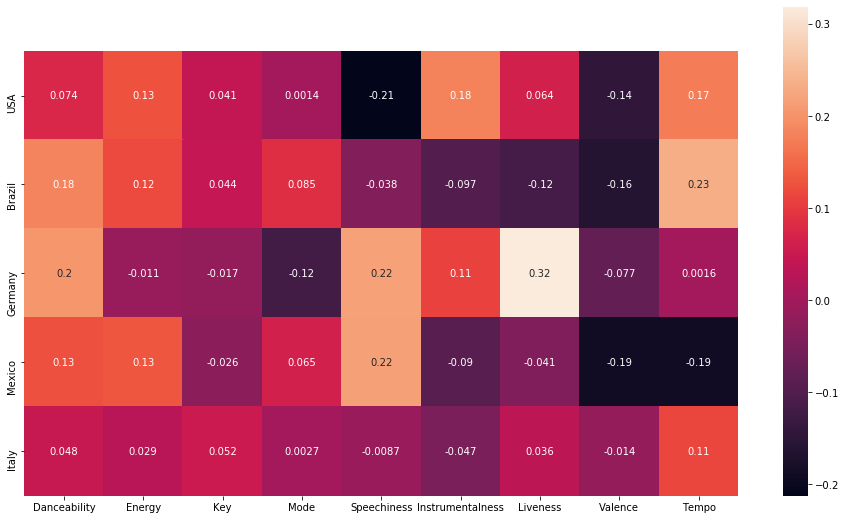

In [65]:
hm_data = [[usaModel.params['Danceability'], usaModel.params['Energy'], usaModel.params['Key'], 
            usaModel.params['Mode'], usaModel.params['Speechiness'], usaModel.params['Instrumentalness'], 
            usaModel.params['Liveness'], usaModel.params['Valence'], usaModel.params['Tempo']],
           [brazilModel.params['Danceability'], brazilModel.params['Energy'], brazilModel.params['Key'], 
            brazilModel.params['Mode'], brazilModel.params['Speechiness'], brazilModel.params['Instrumentalness'], 
            brazilModel.params['Liveness'], brazilModel.params['Valence'], brazilModel.params['Tempo']],
           [germanyModel.params['Danceability'], germanyModel.params['Energy'], germanyModel.params['Key'], 
            germanyModel.params['Mode'], germanyModel.params['Speechiness'], germanyModel.params['Instrumentalness'], 
            germanyModel.params['Liveness'], germanyModel.params['Valence'], germanyModel.params['Tempo']],
           [mexicoModel.params['Danceability'], mexicoModel.params['Energy'], mexicoModel.params['Key'], 
            mexicoModel.params['Mode'], mexicoModel.params['Speechiness'], mexicoModel.params['Instrumentalness'], 
            mexicoModel.params['Liveness'], mexicoModel.params['Valence'], mexicoModel.params['Tempo']],
           [italyModel.params['Danceability'], italyModel.params['Energy'], italyModel.params['Key'], 
            italyModel.params['Mode'], italyModel.params['Speechiness'], italyModel.params['Instrumentalness'], 
            italyModel.params['Liveness'], italyModel.params['Valence'], italyModel.params['Tempo']]]
           
hm = sns.heatmap(hm_data, annot=True, xticklabels=['Danceability', 'Energy', 'Key', 'Mode', 'Speechiness', 
                                                   'Instrumentalness', 'Liveness', 'Valence', 'Tempo'], 
                 yticklabels=['USA', 'Brazil', 'Germany', 'Mexico', 'Italy'])
hm.set_ylim(len(hm_data), -0.5)           


We can make a lot of observations by looking at this heatmap.  Darker colors indicate a high negative correlation, while lighter colors indicate a high positive correlation.  Colors in the middle indicate low correlation.  For certain features such as valence, there seems to be a fairly strong negative correlation across the board.  Danceability has a positive correlation in every country, although it is much stronger in some countries than others.  Interestingly, certain features vary greatly in correlation depending on the country.  Specifically, speechiness has a fairly positive correlation in Germany and Mexico, but has a fairly negative correlation in the United States.  Liveness has a high positive correlation in Germany, but a fairly negligible correlation in the other four countries. 


One key takeaway from this heatmap is that although certain features elevate a song's popularity throughout the world, other features are highly dependent on each country.  In addition, although many coefficients were high in relation to one another, overall the coefficients are fairly low, with the largest value being 0.32.  This tells us that although certain audio features will make a song more likely to be popular, it is far from an exact predictive science.

## Moving Forward
In this tutorial, we have only scratched the surface of answering the questions posed in the introduction.  To truly analyze what makes a song popular, we would need a much larger set of data gathered over a long period of time.  However, this a good starting point.  

In the future with a stronger predictive model, a rising artist could be able to enter information about their song and predict whether or not it will be a hit. This could be especially useful in deciding which song on an album to promote and release as a single. Preconceived notions exist about what will make a song popular, but with the utilization of machine learning, the data will show what actually does.
